In [1]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [16]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
df_full <- dbGetQuery(con, "
    select update_from_id, update_to_id, downstream_package_id, (unnest(oldnesses)).* from historic_solver_job_results_oldnesses
    where array_length(oldnesses, 1) is not null
")

In [21]:
df_sub <- df_full[sample(nrow(df_full), 10000),] 

In [34]:
df <- df_full

In [35]:
downstream_oldness_stats <- df %>% 
    group_by(downstream_package_id) %>% 
    summarise(
        n = n(),
        mean_old_secs = mean(as.numeric(old_secs)),
        num_old = sum(old_secs > 10),
        perc_old = num_old / n
    ) %>% arrange(desc(n))

In [36]:
head(downstream_oldness_stats)

downstream_package_id,n,mean_old_secs,num_old,perc_old
<int64>,<int>,<dbl>,<int>,<dbl>
2004852,1641,63550273,869,0.5295551
1636980,1627,15750136,507,0.3116165
1225879,1612,15663530,529,0.3281638
2213981,1587,18806160,565,0.3560176
669170,1578,18141167,543,0.3441065
1527028,1556,18016320,567,0.3643959


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


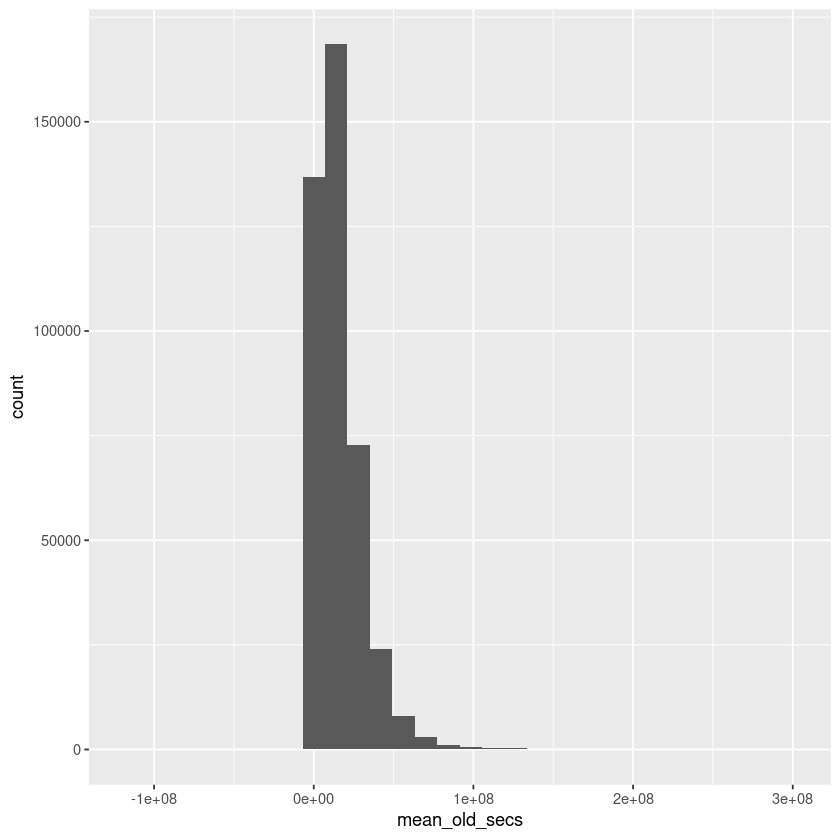

In [38]:
ggplot(data=downstream_oldness_stats, aes(x=mean_old_secs)) + 
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


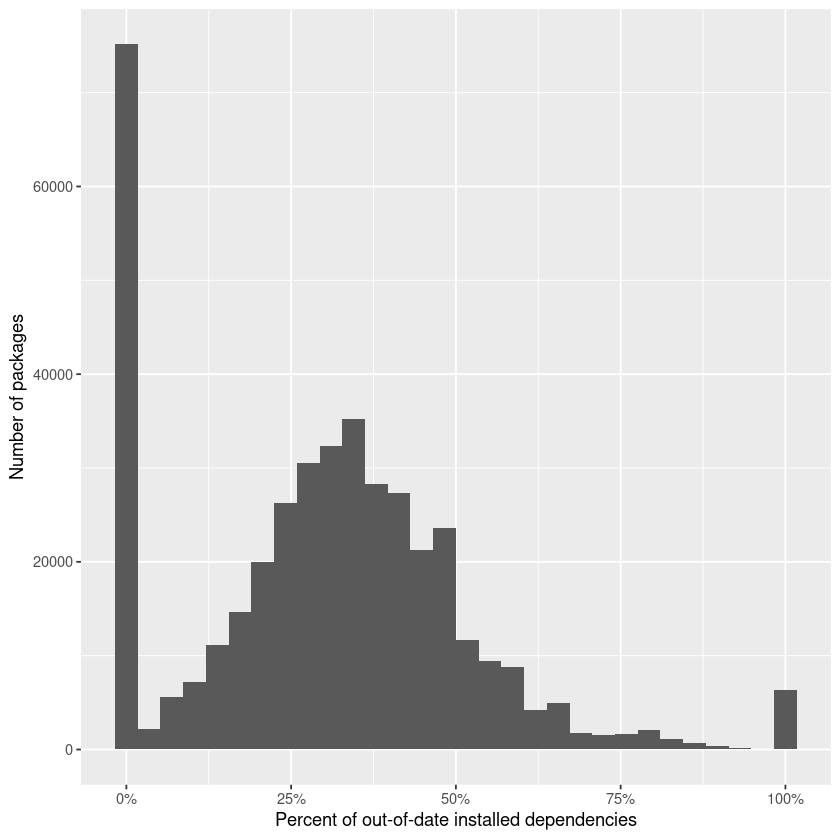

In [66]:

ggplot(data=downstream_oldness_stats, aes(x=perc_old)) + 
    geom_histogram() +
    scale_x_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Number of packages")

ggsave("plots/rq3/perc_old_hist.pdf")

Saving 6.67 x 6.67 in image


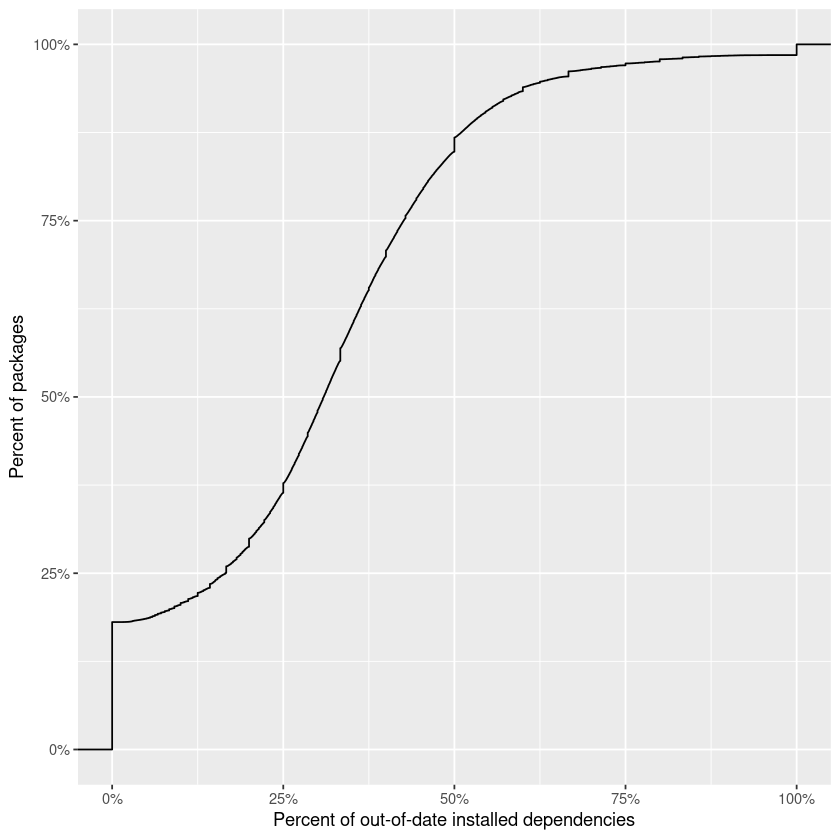

In [50]:
ggplot(data=downstream_oldness_stats, aes(x=perc_old)) + 
    stat_ecdf() +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Percent of packages")

ggsave("plots/rq3/perc_old_ecdf.pdf")

In [73]:
downstream_oldness_stats %>% summarise(mean(n))

mean(n)
<dbl>
164.0915


In [72]:
downstream_oldness_stats %>% filter(perc_old == 0) %>% summarise(mean(n))

mean(n)
<dbl>
2.844209


In [74]:
downstream_oldness_stats %>% filter(perc_old > 0) %>% summarise(mean(n))

mean(n)
<dbl>
199.6576


In [84]:
downstream_oldness_stats %>% 
# filter(perc_old > 0) %>% 
summarise(mean(as.numeric(mean_old_secs))) / (60 * 60 * 24)

mean(as.numeric(mean_old_secs))
<dbl>
178.3691


In [64]:
downstream_oldness_stats %>% group_by(round(perc_old * 100)) %>% summarise(mean(n))

round(perc_old * 100),mean(n)
<dbl>,<dbl>
0,2.844209
1,77.700000
2,48.787234
3,38.230077
4,38.286392
5,34.948990
6,28.475429
7,32.469657
8,31.316164


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


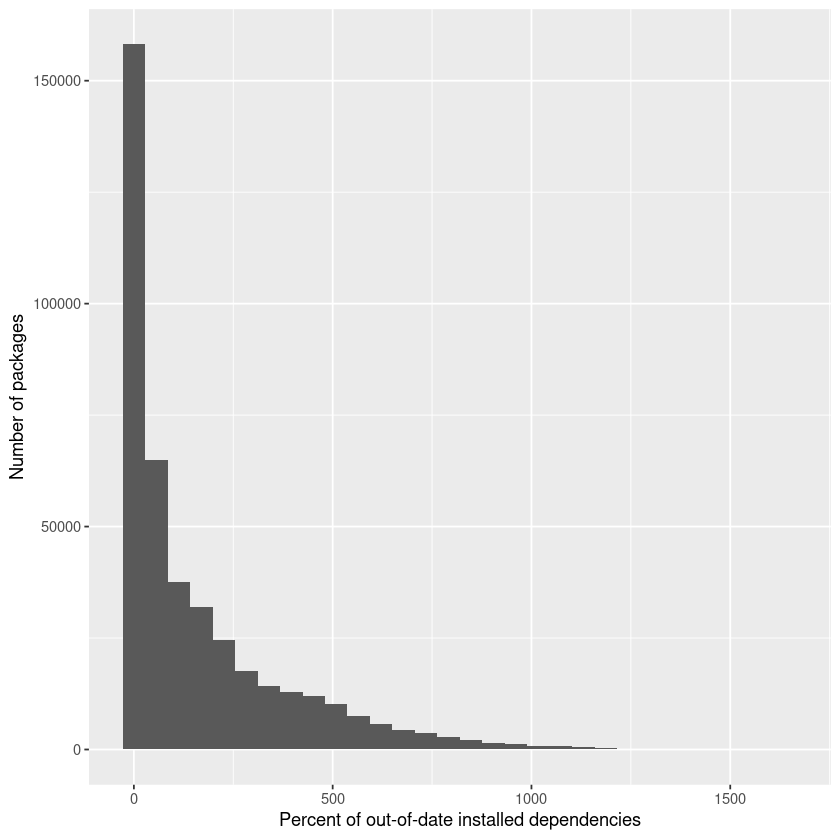

In [56]:
ggplot(data=downstream_oldness_stats, aes(x=n)) + 
    geom_histogram() +
    # scale_x_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Number of packages")

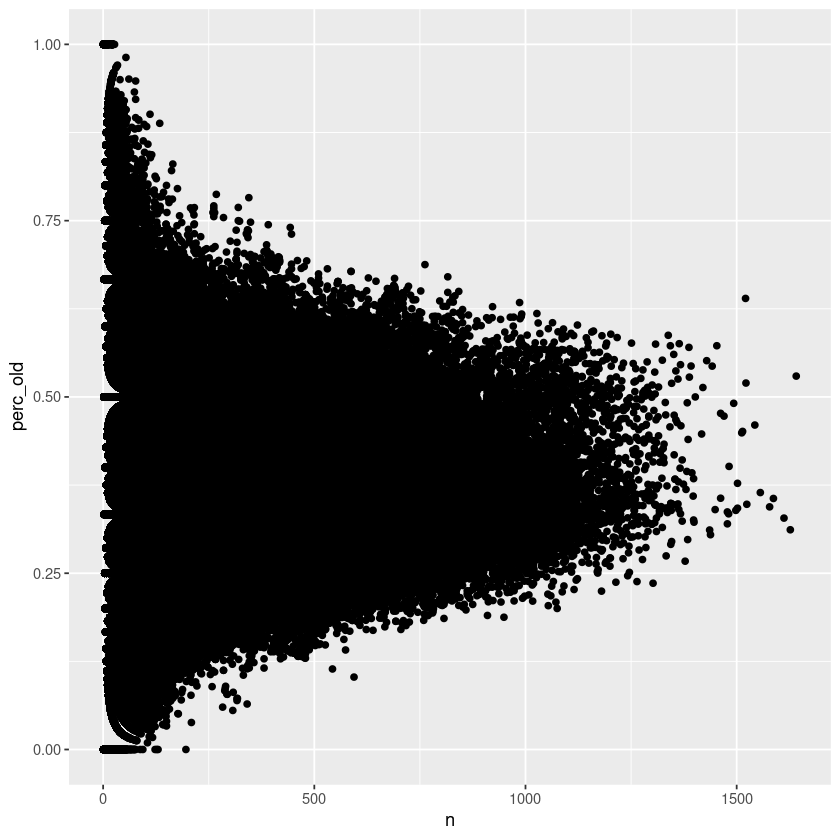

In [52]:
ggplot(data=downstream_oldness_stats, aes(x=n, y=perc_old)) + 
    geom_point() #+
    # scale_x_continuous(labels = scales::percent) +
    # scale_y_continuous(labels = scales::percent) +
    # xlab("Percent of out-of-date installed dependencies") +
    # ylab("Percent of packages")

# ggsave("plots/rq3/perc_old_ecdf.pdf")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


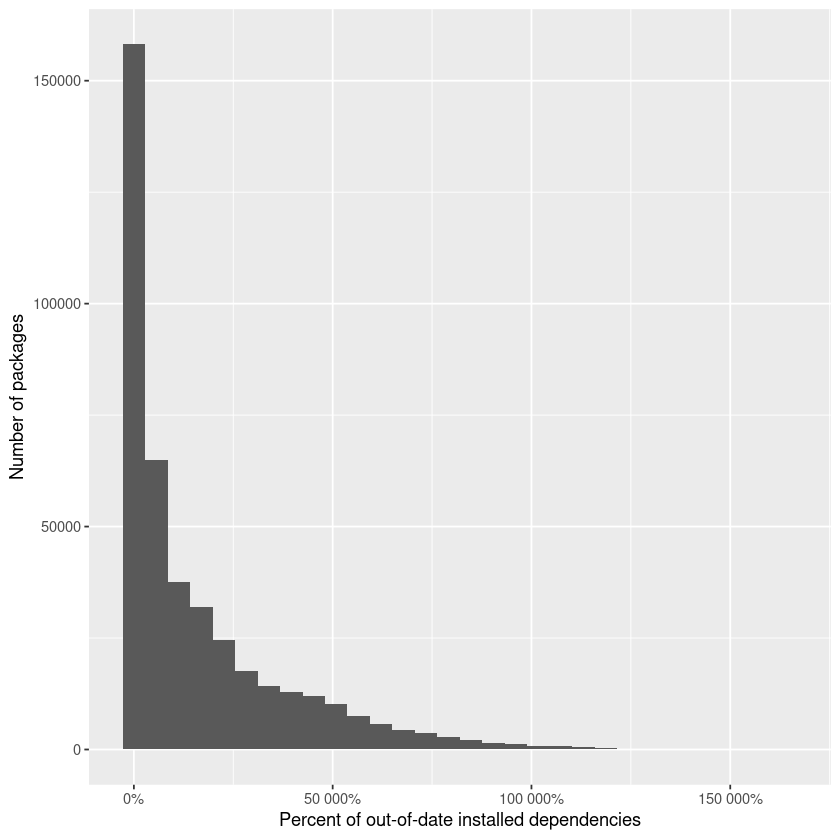

In [53]:
ggplot(data=downstream_oldness_stats, aes(x=n)) + 
    geom_histogram() +
    scale_x_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Number of packages")